# Importing Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from glob import glob
from collections import Counter

# Suppress Warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Constants and Configurations

In [27]:
TRAIN_PATH = "G:\waste_classification\DATASET\DATASET\TRAIN"
TEST_PATH = "G:\waste_classification\DATASET\DATASET\TEST"
BATCH_SIZE = 8
IMG_SIZE = (224, 224)
EPOCHS = 4

# Helper Functions

In [5]:
def load_and_preprocess_data(path):
    """Load and preprocess image data."""
    x_data, y_data = [], []
    for category in glob(f"{path}/*"):
        label = os.path.basename(category)
        for file in tqdm(glob(f"{category}/*"), desc=f"Processing {label}"):
            img_array = cv2.imread(file)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            img_array = cv2.resize(img_array, IMG_SIZE)
            x_data.append(img_array)
            y_data.append(label)
    return np.array(x_data), np.array(y_data)

In [6]:
def visualize_data(x_data, y_data, labels):
    """Visualize random samples and data distribution."""
    # Pie Chart of Label Distribution
    plt.pie(Counter(y_data).values(),
            labels=labels, 
            startangle=90, explode=[0.05] * len(labels), autopct='%0.2f%%',
            colors=['#a0d157', '#c48bb8'], radius=1.5)
    plt.show()

    # Random Sample Visualization
    plt.figure(figsize=(20, 15))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        idx = np.random.randint(len(x_data))
        plt.imshow(x_data[idx])
        plt.title(f"Label: {y_data[idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [7]:
def create_model(input_shape, num_classes):
    """Create a CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Load and Preprocess Data

In [8]:
print("Loading Training Data...")
x_train, y_train = load_and_preprocess_data(TRAIN_PATH)
print("Loading Testing Data...")
x_test, y_test = load_and_preprocess_data(TEST_PATH)

Loading Training Data...


Processing R: 100%|████████████████████████████████████████████████████████████████| 9999/9999 [02:25<00:00, 68.72it/s]


Loading Testing Data...


Processing R: 100%|████████████████████████████████████████████████████████████████| 1112/1112 [00:13<00:00, 83.35it/s]


# Visualization

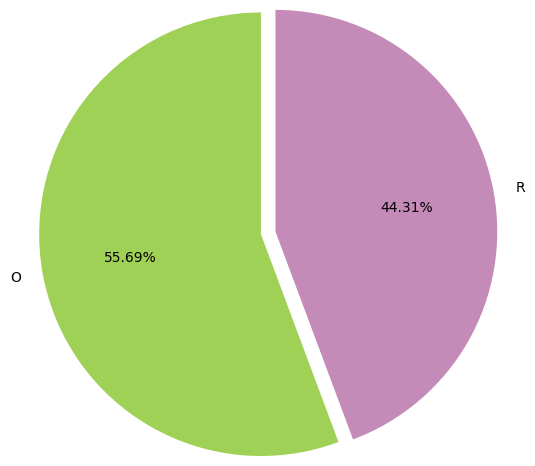

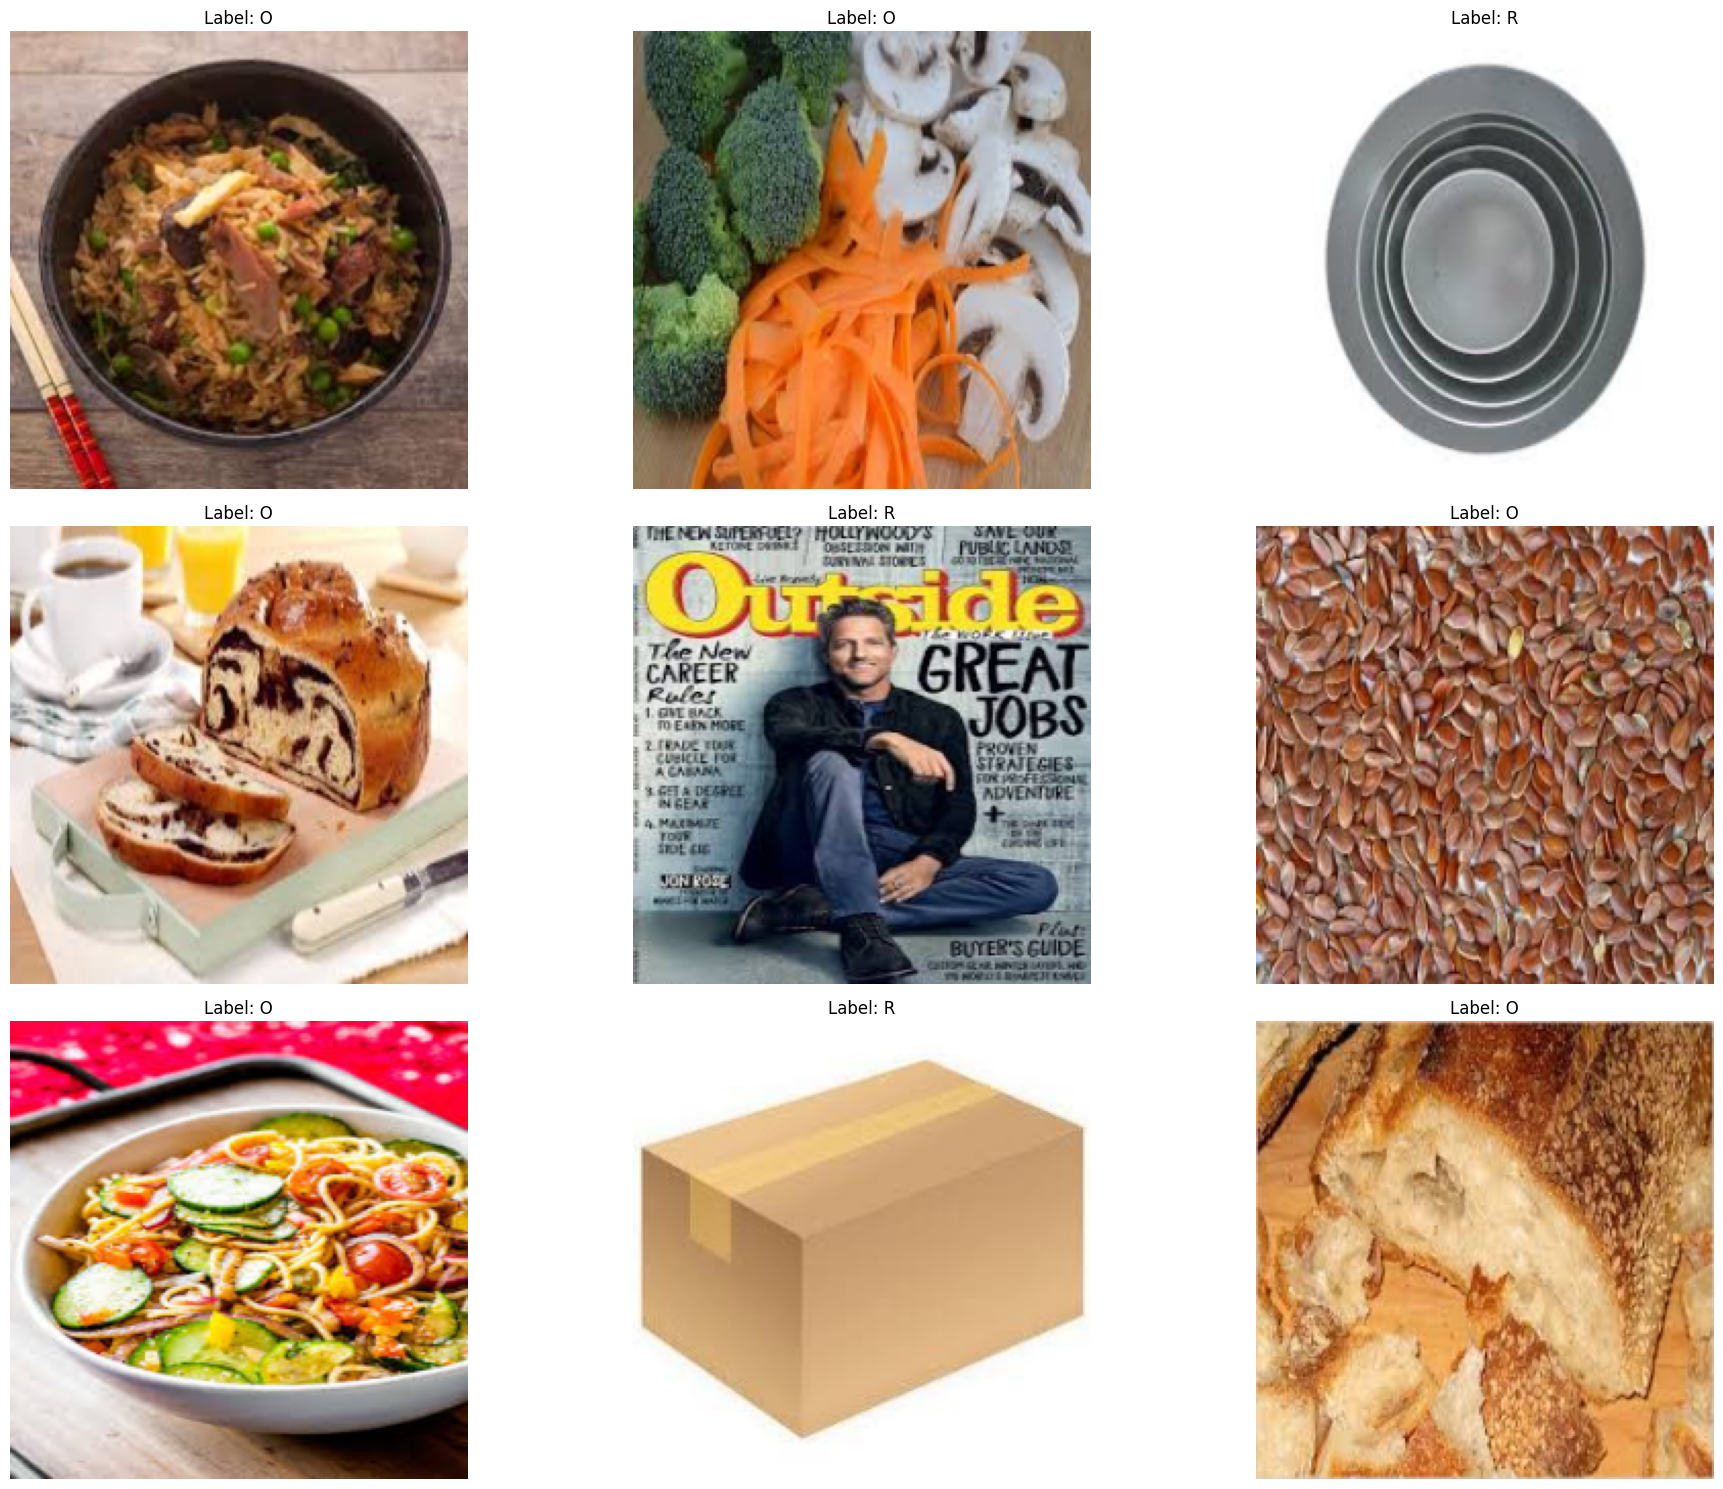

In [9]:
unique_labels = np.unique(y_train)
visualize_data(x_train, y_train, unique_labels)

# Data Augmentation

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 22564 images belonging to 2 classes.


In [29]:
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 2513 images belonging to 2 classes.


# Model Creation

In [30]:
print("Creating Model...")
input_shape = (*IMG_SIZE, 3)
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)

Creating Model...


# Training with Early Stopping

In [31]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/4
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3081s 1s/step - accuracy: 0.5539 - loss: 0.7113 - val_accuracy: 0.5575 - val_loss: 0.6866
Epoch 2/4
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3116s 1s/step - accuracy: 0.5562 - loss: 0.6873 - val_accuracy: 0.5575 - val_loss: 0.6865
Epoch 3/4
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3102s 1s/step - accuracy: 0.5605 - loss: 0.6863 - val_accuracy: 0.5575 - val_loss: 0.6867
Epoch 4/4
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 3027s 1s/step - accuracy: 0.5499 - loss: 0.6883 - val_accuracy: 0.5575 - val_loss: 0.6865


# Visualization of Training History

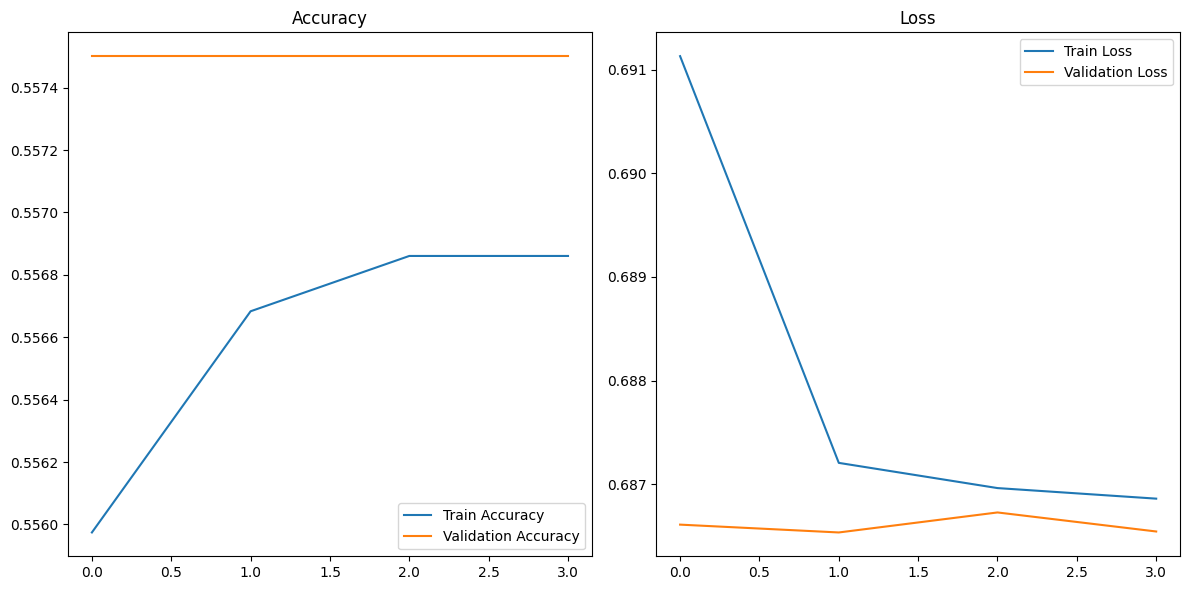

In [34]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.tight_layout()
    plt.show()

plot_history(history)

## Model Prediction

In [44]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
This image -> Recyclable


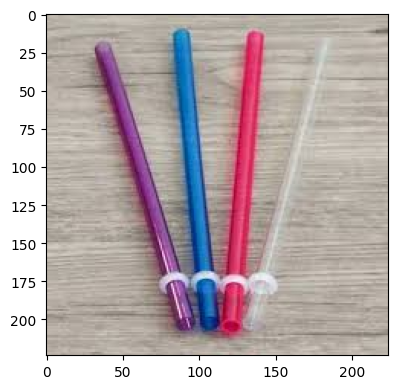

In [45]:
test_img = cv2.imread("G:\waste_classification\DATASET\TEST\R\R_10608.jpg")
predict_func(test_img)

In [46]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 1: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==0: print("\033[94m"+"This image -> Organic"+"\033[0m")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
This image -> Organic


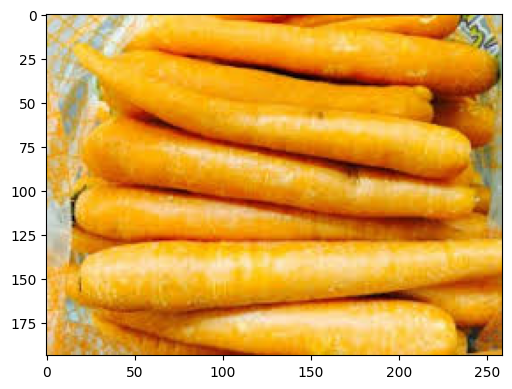

In [47]:
test= cv2.imread("G:\waste_classification\DATASET\TEST\O\O_12616.jpg")
predict_func(test)